# Sentiment Analysis to predict stock price direction using Classifier models

## 1. Introduction
A selection of machine learning classifier models will be used to predict whether the next day Adjusted Close price of Reliance Industry stock will increase or decrease based on sentiment analysis of market news articles from 2011-2023 collected by web scraping from [moneycontrol.com](https://www.moneycontrol.com/company-article/relianceindustries/news/RI). 

Sentiment Analysis is the use of NLP, text analysis and computational linguistics to determine subjective information. Instead of building our own lexicon to do this, we will use VADER (Valence Aware Dictionary and sEntiment Reasoner), a pre-trained sentiment analysis model included in the NLTK package. We will also use TextBlob, a simple API built upon NLTK, for common NLP tasks.




## 2. Import libraries

In [95]:
# Load, explore, process and plot data
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pk
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Train Test Split
from sklearn.model_selection import train_test_split,cross_val_score

#Text Preprocessing
import nltk
from datetime import date, timedelta
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Machine Larning Modeling
import sklearn
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale

#Machine Larning Modeling
import sklearn
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV


# Deep Learning Modeling
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Embedding,SpatialDropout1D, Dropout, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences



# Performance metrices
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.utils.np_utils import to_categorical


# Deep Learning Modeling
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Embedding,SpatialDropout1D, Dropout, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences



# Performance metrices
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.utils.np_utils import to_categorical

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 3. Import data

Read article sentiment data collected by web scraping from Investing.com into a DataFrame.



In [2]:
# Show DataFrame of article sentiments data

article_sentiments = pd.read_csv('News_Data/RI(2011_2023)_articleBody_Sentiment_Score.csv') 


In [3]:
article_sentiments['datePublished'] = pd.to_datetime(article_sentiments['datePublished'])
article_sentiments['datePublished'] = article_sentiments['datePublished'].dt.date


In [4]:
# Create copy of DataFrame

article_sentiments_RI = article_sentiments.copy()


## 4. Clean news data

Prepare data for further processing by appending separator to body text of each article.

In [5]:
# Append ---newarticle--- to split for NLP

article_sentiments_RI['articleBody'] = article_sentiments_RI['articleBody'].astype(str) + '---newarticle---'

In [6]:
RI_articleBody = article_sentiments_RI['articleBody']


In [7]:
pd.set_option("display.max_colwidth", 1)  # to display full text


In [8]:
# Save article_sentiments_azn to txt

with open('RI_articleBody_20112023.txt', 'w') as f:
    f.write(
        RI_articleBody.to_string(header = False, index = False)
    )

### Remove spaces in text file

In [9]:
# first get all lines from file
with open('RI_articleBody_20112023.txt', 'r') as f:
    lines = f.readlines()

# remove spaces
lines = [line.replace(' ', '') for line in lines]

# finally, write lines in the file
with open('RI_articleBody_20112023.txt', 'w') as f:
    f.writelines(lines)

### Remove end line breaks from text file

In [10]:
# first get all lines from file
a_file = open("RI_articleBody_20112023.txt", "r")

# create variable for string without line breaks
string_without_line_breaks = ""

# iterate over strings 
for line in a_file:
  stripped_line = line.rstrip() # rstrip() method removes any trailing characters - space is the default trailing character to remove
  string_without_line_breaks += stripped_line
a_file.close()

In [11]:
# finally, write lines in the file
with open('RI_articleBody_20112023.txt', 'w') as f:
    f.writelines(string_without_line_breaks)

In [12]:
# Read article sentiments data into DataFrame 

RI_news_df = pd.read_csv('News_Data/RI(2011_2023)_articleBody_Sentiment_Score.csv')
RI_news_df['datePublished'] = pd.to_datetime(RI_news_df['datePublished'])
RI_news_df['datePublished'] = RI_news_df['datePublished'].dt.date


In [13]:
# Check data types

RI_news_df.dtypes

S. No.           int64  
company          object 
datePublished    object 
author           object 
headline         object 
description      object 
tags             object 
url              object 
articleBody      object 
neg              float64
neu              float64
pos              float64
compound         float64
dtype: object

In [14]:
# Create copy of DataFrame

RI_news_df_new = RI_news_df.copy()

### Drop rows without publish date

In [15]:
# Drop rows with None in publish_date column

RI_news_df_new = RI_news_df_new.replace(to_replace='None', value=np.nan).dropna()
RI_news_df_new.head(1)

S. No. company datePublished   
0  1       RI      2011-01-03    \

                                          author   
0  {'@type': 'Person', 'name': 'webtech_news18'}  \

                                                     headline   
0  RIL commissions biz transformation plans for FY12: sources  \

                                                                                                             description   
0  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources.  \

                                                 tags   
0  BP, Business, E&P, exploration, Jamnagar, oil, RIL  \

                                                                                                                 url   
0  https://www.moneycontrol.com//news/business/ril-commissions-biz-transformation-plans-for-fy12-sources_509910.html  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              articleBody   
0  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources. It is learnt that RIL has mandated ATKearney and Booz &amp;amp;amp; Co for business transformation to make it process driven on the lines of Exxon and Shell. Sources add that RIL is likely to finalise a USD 5 billion plan at Jamnagar in 2011 which includes new cracker and downstream expansion. The decision on building LNG terminal may be taken in 2011. However, it may not be in Jamnagar.  Further RIL has revived talks with BP to sell stake in exploration and production (E&amp;amp;amp;P) assets.  &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp;  \

   neg    neu    pos  compound  
0  0.0  0.965  0.035  0.3818

### Drop rows with duplicate titles

In [16]:
# Dropping all duplicate titles keeping only the first instance

RI_news_df_new.drop_duplicates(subset ="headline", 
                     keep = 'first', inplace = True)

RI_news_df_new.head(1)

S. No. company datePublished   
0  1       RI      2011-01-03    \

                                          author   
0  {'@type': 'Person', 'name': 'webtech_news18'}  \

                                                     headline   
0  RIL commissions biz transformation plans for FY12: sources  \

                                                                                                             description   
0  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources.  \

                                                 tags   
0  BP, Business, E&P, exploration, Jamnagar, oil, RIL  \

                                                                                                                 url   
0  https://www.moneycontrol.com//news/business/ril-commissions-biz-transformation-plans-for-fy12-sources_509910.html  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              articleBody   
0  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources. It is learnt that RIL has mandated ATKearney and Booz &amp;amp;amp; Co for business transformation to make it process driven on the lines of Exxon and Shell. Sources add that RIL is likely to finalise a USD 5 billion plan at Jamnagar in 2011 which includes new cracker and downstream expansion. The decision on building LNG terminal may be taken in 2011. However, it may not be in Jamnagar.  Further RIL has revived talks with BP to sell stake in exploration and production (E&amp;amp;amp;P) assets.  &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp;  \

   neg    neu    pos  compound  
0  0.0  0.965  0.035  0.3818

### Set datetime index

In [17]:
RI_news_df_new.dtypes

S. No.           int64  
company          object 
datePublished    object 
author           object 
headline         object 
description      object 
tags             object 
url              object 
articleBody      object 
neg              float64
neu              float64
pos              float64
compound         float64
dtype: object

In [18]:
# Set string representation of date to datetime index

RI_news_df_new['Date'] = pd.to_datetime(RI_news_df_new.datePublished)
RI_news_df_new.set_index('Date', inplace=True)
RI_news_df_new.head(1)

S. No. company datePublished   
Date                                       
2011-01-03  1       RI      2011-01-03    \

                                                   author   
Date                                                        
2011-01-03  {'@type': 'Person', 'name': 'webtech_news18'}  \

                                                              headline   
Date                                                                     
2011-01-03  RIL commissions biz transformation plans for FY12: sources  \

                                                                                                                      description   
Date                                                                                                                                
2011-01-03  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources.  \

                                                          tags   
Date                                                             
2011-01-03  BP, Business, E&P, exploration, Jamnagar, oil, RIL  \

                                                                                                                          url   
Date                                                                                                                            
2011-01-03  https://www.moneycontrol.com//news/business/ril-commissions-biz-transformation-plans-for-fy12-sources_509910.html  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       articleBody   
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2011-01-03  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources. It is learnt that RIL has mandated ATKearney and Booz &amp;amp;amp; Co for business transformation to make it process driven on the lines of Exxon and Shell. Sources add that RIL is likely to finalise a USD 5 billion plan at Jamnagar in 2011 which includes new cracker and downstream expansion. The decision on building LNG terminal may be taken in 2011. However, it may not be in Jamnagar.  Further RIL has revived talks with BP to sell stake in exploration and production (E&amp;amp;amp;P) assets.  &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp;  \

            neg    neu    pos  compound  
Date                                     
2011-01-03  0.0  0.965  0.035  0.3818

In [19]:
# Show dateime index of new DataFrame

RI_news_df_new.index

DatetimeIndex(['2011-01-03', '2011-01-11', '2011-01-13', '2011-01-17',
               '2011-01-20', '2011-01-21', '2011-01-21', '2011-01-21',
               '2011-01-24', '2011-01-27',
               ...
               '2023-03-31', '2023-03-31', '2023-04-03', '2023-04-20',
               '2023-04-21', '2023-04-21', '2023-04-21', '2023-04-22',
               '2023-04-24', '2023-05-01'],
              dtype='datetime64[ns]', name='Date', length=2019, freq=None)

### Sort in ascending chronological order

In [20]:
# Sort in chronological order

RI_news_df_new = RI_news_df_new.sort_index()
RI_news_df_new.head(1)

S. No. company datePublished   
Date                                       
2011-01-03  1       RI      2011-01-03    \

                                                   author   
Date                                                        
2011-01-03  {'@type': 'Person', 'name': 'webtech_news18'}  \

                                                              headline   
Date                                                                     
2011-01-03  RIL commissions biz transformation plans for FY12: sources  \

                                                                                                                      description   
Date                                                                                                                                
2011-01-03  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources.  \

                                                          tags   
Date                                                             
2011-01-03  BP, Business, E&P, exploration, Jamnagar, oil, RIL  \

                                                                                                                          url   
Date                                                                                                                            
2011-01-03  https://www.moneycontrol.com//news/business/ril-commissions-biz-transformation-plans-for-fy12-sources_509910.html  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       articleBody   
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2011-01-03  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources. It is learnt that RIL has mandated ATKearney and Booz &amp;amp;amp; Co for business transformation to make it process driven on the lines of Exxon and Shell. Sources add that RIL is likely to finalise a USD 5 billion plan at Jamnagar in 2011 which includes new cracker and downstream expansion. The decision on building LNG terminal may be taken in 2011. However, it may not be in Jamnagar.  Further RIL has revived talks with BP to sell stake in exploration and production (E&amp;amp;amp;P) assets.  &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp;  \

            neg    neu    pos  compound  
Date                                     
2011-01-03  0.0  0.965  0.035  0.3818

In [21]:
# Save sorted DataFrame 

RI_news_df_new.to_pickle("RI_news_df_new_20112023.pkl")

In [22]:
RI_news_df_new.to_csv("RI_news_df_new_20112023.csv", sep=',', encoding='utf-8', header=True)

In [23]:
RI_news_df_new.dtypes

S. No.           int64  
company          object 
datePublished    object 
author           object 
headline         object 
description      object 
tags             object 
url              object 
articleBody      object 
neg              float64
neu              float64
pos              float64
compound         float64
dtype: object

In [24]:
# Create copy of DataFrame 

RI_news_df_combined = RI_news_df_new.copy()

### Combine articles published on same date

Combine all news articles published on same date to get a single score. An alternative method could be to take the mean score of all articles published on the same date.

In [25]:
# Combining all the news published on a single date in a separate column

RI_news_df_combined['news_combined'] = RI_news_df_combined.groupby(['datePublished'])['articleBody'].transform(lambda x: ' '.join(x))

RI_news_df_combined.head(1)

S. No. company datePublished   
Date                                       
2011-01-03  1       RI      2011-01-03    \

                                                   author   
Date                                                        
2011-01-03  {'@type': 'Person', 'name': 'webtech_news18'}  \

                                                              headline   
Date                                                                     
2011-01-03  RIL commissions biz transformation plans for FY12: sources  \

                                                                                                                      description   
Date                                                                                                                                
2011-01-03  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources.  \

                                                          tags   
Date                                                             
2011-01-03  BP, Business, E&P, exploration, Jamnagar, oil, RIL  \

                                                                                                                          url   
Date                                                                                                                            
2011-01-03  https://www.moneycontrol.com//news/business/ril-commissions-biz-transformation-plans-for-fy12-sources_509910.html  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       articleBody   
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2011-01-03  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources. It is learnt that RIL has mandated ATKearney and Booz &amp;amp;amp; Co for business transformation to make it process driven on the lines of Exxon and Shell. Sources add that RIL is likely to finalise a USD 5 billion plan at Jamnagar in 2011 which includes new cracker and downstream expansion. The decision on building LNG terminal may be taken in 2011. However, it may not be in Jamnagar.  Further RIL has revived talks with BP to sell stake in exploration and production (E&amp;amp;amp;P) assets.  &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp;  \

            neg    neu    pos  compound   
Date                                      
2011-01-03  0.0  0.965  0.035  0.3818    \

                                                                                                                                                                                                                                                                                

### Drop rows with duplicate dates

In [26]:
# Dropping duplicate dates keeping only the first instance

RI_news_df_combined.drop_duplicates(subset ="datePublished", 
                     keep = 'first', inplace = True)

In [27]:
# Show DataFrame to check that the number of rows has decreased

RI_news_df_combined.head(1)

S. No. company datePublished   
Date                                       
2011-01-03  1       RI      2011-01-03    \

                                                   author   
Date                                                        
2011-01-03  {'@type': 'Person', 'name': 'webtech_news18'}  \

                                                              headline   
Date                                                                     
2011-01-03  RIL commissions biz transformation plans for FY12: sources  \

                                                                                                                      description   
Date                                                                                                                                
2011-01-03  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources.  \

                                                          tags   
Date                                                             
2011-01-03  BP, Business, E&P, exploration, Jamnagar, oil, RIL  \

                                                                                                                          url   
Date                                                                                                                            
2011-01-03  https://www.moneycontrol.com//news/business/ril-commissions-biz-transformation-plans-for-fy12-sources_509910.html  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       articleBody   
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2011-01-03  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources. It is learnt that RIL has mandated ATKearney and Booz &amp;amp;amp; Co for business transformation to make it process driven on the lines of Exxon and Shell. Sources add that RIL is likely to finalise a USD 5 billion plan at Jamnagar in 2011 which includes new cracker and downstream expansion. The decision on building LNG terminal may be taken in 2011. However, it may not be in Jamnagar.  Further RIL has revived talks with BP to sell stake in exploration and production (E&amp;amp;amp;P) assets.  &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp;  \

            neg    neu    pos  compound   
Date                                      
2011-01-03  0.0  0.965  0.035  0.3818    \

                                                                                                                                                                                                                                                                                

In [28]:
# Save combined DataFrame without duplicates

RI_news_df_combined.to_csv("RI_news_df_combined_20112023.csv", sep=',', encoding='utf-8', header=True)

In [29]:
RI_news_df_combined = pd.read_csv("RI_news_df_combined_20112023.csv")
RI_news_df_combined.head()

Date  S. No. company datePublished   
0  2011-01-03  1       RI      2011-01-03    \
1  2011-01-11  3       RI      2011-01-11     
2  2011-01-13  5       RI      2011-01-13     
3  2011-01-17  7       RI      2011-01-17     
4  2011-01-20  9       RI      2011-01-20     

                                          author   
0  {'@type': 'Person', 'name': 'webtech_news18'}  \
1  {'@type': 'Person', 'name': 'webtech_news18'}   
2  {'@type': 'Person', 'name': 'Rakesh Patil'}     
3  {'@type': 'Person', 'name': 'webtech_news18'}   
4  {'@type': 'Person', 'name': 'webtech_news18'}   

                                                      headline   
0  RIL commissions biz transformation plans for FY12: sources   \
1  Reliance Industries D6 block capacity falls to 52-53 mmscmd   
2  RIL Dec qtr PAT seen up 38% at Rs 5535cr: Angel               
3  Stable outlook for Indian oil and gas sector in 2011: Fitch   
4  RIL Q3 net profit seen up 29.7% to Rs 5200 cr                 

                                                                                                                                                                                                                                                                                                              description   
0  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources.                                                                                                                                                                                                   \
1  Reliance Industries has a current gas output capacity of 52-53 mn metric standard cubic metres a day (mmscmd) at its D6 block in Krishna-Godavari basin, head of India's upstream regulator said, lower than 60 mmscmd seen in last October.                                                                             
2  Angel Broking has come out with its earning estimates on the oil &amp;amp; gas sector for the quarter ended December 2010. According to the research firm, RIL December quarter net sales are expected to go up by 20.2% to Rs 68,347 crore, Year-on-Year, (Y-o-Y) basis.                                                
3  Fitch Ratings said, in a just published report, that the outlook for India's oil and gas industry is stable for 2011. This is based on the agency's expectation that ties between the government and its majority-owned oil companies will not weaken.                                                                   
4  The flagship company of Reliance Group, Reliance Industries (RIL) is set to announce its results for the quarter ended December 2010. According to CNBC-TV18 estimates, its net profit is expected to go up by 29.7% to Rs 5,200 crore in Q3FY11 as against Rs 4,008 crore in same quarter of previous financial year.   

                                                                                          tags   
0  BP, Business, E&P, exploration, Jamnagar, oil, RIL                                           \
1  Business, D6 block, India's upstream regulator, Krishna-Godavari basin, Reliance Industries   
2  Angel Broking, Brokerage Results Estimates, RIL                                               
3  Business, crude oil prices, Fitch Ratings, India, oil and gas industry                        
4  Reliance Industries, Result Poll, RIL                                                         

                                                                                                                    url   
0  https://www.moneycontrol.com//news/business/ril-commissions-biz-transformation-plans-for-fy12-sources_509910.html     \
1  https://www.moneycontrol.com//news/business/reliance-industries-d6-block-capacity-falls-to-52-53-mmscmd_512246.html    
2  https://www.moneycontrol.com//news/brokerage-results-estimates/ril-dec-qtr-pat-seen38-at-rs-5535cr-angel_512983.html   
3  https://www.moneycontrol.com/

### Set datetime index

In [30]:
# Set string representation of date to datetime index

RI_news_df_combined['Date'] = pd.to_datetime(RI_news_df_combined.datePublished)
RI_news_df_combined.set_index('Date', inplace=True)
RI_news_df_combined.head(1)

S. No. company datePublished   
Date                                       
2011-01-03  1       RI      2011-01-03    \

                                                   author   
Date                                                        
2011-01-03  {'@type': 'Person', 'name': 'webtech_news18'}  \

                                                              headline   
Date                                                                     
2011-01-03  RIL commissions biz transformation plans for FY12: sources  \

                                                                                                                      description   
Date                                                                                                                                
2011-01-03  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources.  \

                                                          tags   
Date                                                             
2011-01-03  BP, Business, E&P, exploration, Jamnagar, oil, RIL  \

                                                                                                                          url   
Date                                                                                                                            
2011-01-03  https://www.moneycontrol.com//news/business/ril-commissions-biz-transformation-plans-for-fy12-sources_509910.html  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       articleBody   
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2011-01-03  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources. It is learnt that RIL has mandated ATKearney and Booz &amp;amp;amp; Co for business transformation to make it process driven on the lines of Exxon and Shell. Sources add that RIL is likely to finalise a USD 5 billion plan at Jamnagar in 2011 which includes new cracker and downstream expansion. The decision on building LNG terminal may be taken in 2011. However, it may not be in Jamnagar.  Further RIL has revived talks with BP to sell stake in exploration and production (E&amp;amp;amp;P) assets.  &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp;  \

            neg    neu    pos  compound   
Date                                      
2011-01-03  0.0  0.965  0.035  0.3818    \

                                                                                                                                                                                                                                                                                

## 5. Import historical stock data 

Import stock data for same period as news data from Yahoo! Finance using yfinance API.

In [31]:
RI_stock_df = yf.download("RELIANCE.NS", start="2011-04-03", end="2023-03-31")
RI_stock_df

[*********************100%***********************]  1 of 1 completed


Open         High          Low        Close    Adj Close   
Date                                                                          
2011-04-04  515.117188   522.447693   509.668854   520.392212   474.875397   \
2011-04-05  521.308533   524.528015   515.117188   518.906311   473.519440    
2011-04-06  517.593750   522.175293   515.117188   517.519409   472.253845    
2011-04-07  517.618469   518.856750   512.690186   516.058289   470.920532    
2011-04-08  516.107788   520.516052   505.533051   507.142792   462.784851    
...                ...          ...          ...          ...          ...    
2023-03-23  2268.000000  2269.899902  2243.050049  2247.800049  2247.800049   
2023-03-24  2245.250000  2250.000000  2198.000000  2203.300049  2203.300049   
2023-03-27  2217.500000  2254.000000  2200.199951  2237.550049  2237.550049   
2023-03-28  2245.000000  2256.500000  2237.000000  2248.000000  2248.000000   
2023-03-29  2239.000000  2244.800049  2211.100098  2234.699951  2234.699951   

             Volume  
Date                 
2011-04-04  6051061  
2011-04-05  4964260  
2011-04-06  4191928  
2011-04-07  4690528  
2011-04-08  5536031  
...             ...  
2023-03-23  7499082  
2023-03-24  5711497  
2023-03-27  6486068  
2023-03-28  5804018  
2023-03-29  8678073  

[2957 rows x 6 columns]

### Visualise Adjusted Close price and Volume 

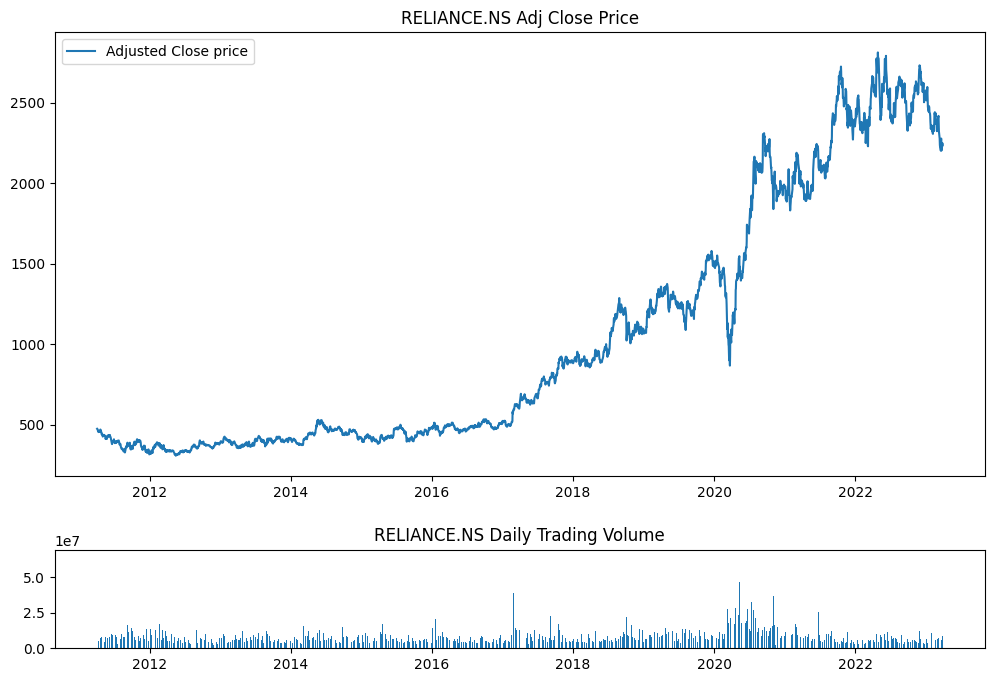

In [32]:
# Plot Adjusted Close price and Volume

top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4) 
top.plot(RI_stock_df.index, RI_stock_df['Adj Close'], label = 'Adjusted Close price') 
plt.title('RELIANCE.NS Adj Close Price') 
plt.legend(loc=2) 
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4) 
bottom.bar(RI_stock_df.index, RI_stock_df["Volume"]) 
plt.title('RELIANCE.NS Daily Trading Volume') 
plt.gcf().set_size_inches(12,8) 
plt.subplots_adjust(hspace=0.75)

## 6. Merge Stock and Sentiment Dataframes on Date

In [33]:
RI_news_df_combined.head(1)

S. No. company datePublished   
Date                                       
2011-01-03  1       RI      2011-01-03    \

                                                   author   
Date                                                        
2011-01-03  {'@type': 'Person', 'name': 'webtech_news18'}  \

                                                              headline   
Date                                                                     
2011-01-03  RIL commissions biz transformation plans for FY12: sources  \

                                                                                                                      description   
Date                                                                                                                                
2011-01-03  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources.  \

                                                          tags   
Date                                                             
2011-01-03  BP, Business, E&P, exploration, Jamnagar, oil, RIL  \

                                                                                                                          url   
Date                                                                                                                            
2011-01-03  https://www.moneycontrol.com//news/business/ril-commissions-biz-transformation-plans-for-fy12-sources_509910.html  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       articleBody   
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2011-01-03  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources. It is learnt that RIL has mandated ATKearney and Booz &amp;amp;amp; Co for business transformation to make it process driven on the lines of Exxon and Shell. Sources add that RIL is likely to finalise a USD 5 billion plan at Jamnagar in 2011 which includes new cracker and downstream expansion. The decision on building LNG terminal may be taken in 2011. However, it may not be in Jamnagar.  Further RIL has revived talks with BP to sell stake in exploration and production (E&amp;amp;amp;P) assets.  &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp;  \

            neg    neu    pos  compound   
Date                                      
2011-01-03  0.0  0.965  0.035  0.3818    \

                                                                                                                                                                                                                                                                                

In [34]:
# Merge data sets on date
merge = RI_stock_df.merge(RI_news_df_combined, how='inner', left_index=True, right_index=True)


In [35]:
# Show merged data set
merge

Open         High          Low        Close    Adj Close   
Date                                                                          
2011-04-04  515.117188   522.447693   509.668854   520.392212   474.875397   \
2011-04-05  521.308533   524.528015   515.117188   518.906311   473.519440    
2011-04-07  517.618469   518.856750   512.690186   516.058289   470.920532    
2011-04-13  496.221313   507.192322   493.620972   506.102661   461.835724    
2011-04-15  504.542450   507.613342   497.781525   505.681641   461.451538    
...                ...          ...          ...          ...          ...    
2023-02-08  2313.000000  2359.899902  2307.000000  2351.949951  2351.949951   
2023-02-14  2329.949951  2381.899902  2323.649902  2378.100098  2378.100098   
2023-02-21  2424.000000  2446.800049  2412.350098  2434.100098  2434.100098   
2023-03-16  2243.000000  2254.000000  2202.199951  2225.899902  2225.899902   
2023-03-20  2215.000000  2220.000000  2180.000000  2201.250000  2201.250000   

             Volume  S. No. company datePublished   
Date                                                
2011-04-04  6051061  139     RI      2011-04-04    \
2011-04-05  4964260  141     RI      2011-04-05     
2011-04-07  4690528  143     RI      2011-04-07     
2011-04-13  8822291  147     RI      2011-04-13     
2011-04-15  6541425  153     RI      2011-04-15     
...             ...  ...     ..             ...     
2023-02-08  9765490  4565    RI      2023-02-08     
2023-02-14  6609564  4566    RI      2023-02-14     
2023-02-21  6143298  4567    RI      2023-02-21     
2023-03-16  8474595  4568    RI      2023-03-16     
2023-03-20  9010595  4569    RI      2023-03-20     

                                                                                                                            author   
Date                                                                                                                                 
2011-04-04  {'@type': 'Person', 'name': 'webtech_news18'}                                                                           \
2011-04-05  {'@type': 'Person', 'name': 'webtech_news18'}                                                                            
2011-04-07  {'@type': 'Person', 'name': 'Rakesh Patil'}                                                                              
2011-04-13  {'@type': 'Person', 'name': 'webtech_news18'}                                                                            
2011-04-15  {'@type': 'Person', 'name': 'webtech_news18'}                                                                            
...                                                   ...                                                                            
2023-02-08  {'@type': 'Person', 'url': 'https://www.moneycontrol.com/author/bloomberg-21811/', 'name': 'Bloomberg'}                  
2023-02-14  {'@type': 'Person', 'url': 'https://www.moneycontrol.com/author/moneycontrol-news-7285/', 'name': 'Moneycontrol News'}   
2023-02-21  {'@type': 'Person', 'url': 'https://www.moneycontrol.com/author/moneycontrol-news-7285/', 'name': 'Moneycontrol News'}   
2023-03-16  {'@type': 'Person', 'url': 'https://www.moneycontrol.com/author/sandip-das-6836/', 'name': 'Sandip Das'}                 
2023-03-20  {'@type': 'Person', 'url': 'https://www.moneycontrol.com/author/moneycontrol-news-7285/', 'name': 'Moneycontrol News'}   

                                                                                                               headline   
Date                                                                                                                      
2011-04-04  Sell Reliance Inds; tgt of Rs 980/960: Aditya Birla Money                                                    \
2011-04-05  RIL March qtr PAT seen up 23% at Rs 4912 cr: KRChoksey                                                        
2011-04-07  Remain invested in Reliance Industries: Sanjay Dutt   

In [50]:
# Save merged DataFrame

merge.to_csv("RI_news_stock_merge_20112023.csv", sep=',', encoding='utf-8', header=True)

In [51]:
# Show first row in combined news column

merge['news_combined'].iloc[0]

'Aditya Birla Money is bearish on Reliance Industries and has recommended sell rating on the stock with a target of Rs 980/960 in its April 4, 2011 research report. '

In [52]:
# Iterate over rows in combined news column

for index, row in merge.iterrows(): 
    print (row["news_combined"])

Aditya Birla Money is bearish on Reliance Industries and has recommended sell rating on the stock with a target of Rs 980/960 in its April 4, 2011 research report. 
KRChoksey has come out with its earning estimates on diversified sector for the quarter ended March 2011. According to the research firm, Reliance Industries March quarter sales are expected to go up by 4% at Rs 61,403 crore, year-on-year, (YoY) basis. The company's net profit is expected to go up by 23% at Rs 4,912 crore on YoY basis.
Remain invested in Reliance Industries, says Sanjay Dutt, Director, Quantum Securities. Dutt told CNBC-TV18, &amp;quot;I am bullish on Reliance but there are DVS designs. So just remain invested in this stock that has also got linked a lot to policy action, which is out there in the public domain, I don
Petroleum Ministry has sought security clearance from Home Ministry for allowing UK's BP Plc to buy 30% stake in most of the Reliance Industries' oil and gas blocks, including the giant KG-D6 

### Clean data in combined news column

Strip newline escape sequence (\n), unwanted punctuation and backslashes.  

In [53]:
# Create empty list to append cleaned data from combined news column

clean_news = []

for i in range(0, len(merge["news_combined"])): 
    clean_news.append(re.sub("\n", ' ', merge["news_combined"][i]))  # replace n\ with ' '
    clean_news[i] = re.sub(r'[^\w\d\s\']+', '', clean_news[i]) # remove unwanted punctuation and \'


In [54]:
# Show first row in cleaned combined news column

clean_news[0]

'Aditya Birla Money is bearish on Reliance Industries and has recommended sell rating on the stock with a target of Rs 980960 in its April 4 2011 research report '

In [55]:
# Add cleaned news column to merged data set

merge['news_cleaned'] = clean_news


merge['news_cleaned'][0]

'Aditya Birla Money is bearish on Reliance Industries and has recommended sell rating on the stock with a target of Rs 980960 in its April 4 2011 research report '

In [42]:
# Show head of merged DataFrame

merge.head()

Open        High         Low       Close   Adj Close   
Date                                                                     
2011-04-04  515.117188  522.447693  509.668854  520.392212  474.875397  \
2011-04-05  521.308533  524.528015  515.117188  518.906311  473.519440   
2011-04-07  517.618469  518.856750  512.690186  516.058289  470.920532   
2011-04-13  496.221313  507.192322  493.620972  506.102661  461.835724   
2011-04-15  504.542450  507.613342  497.781525  505.681641  461.451538   

             Volume  S. No. company datePublished   
Date                                                
2011-04-04  6051061  139     RI      2011-04-04    \
2011-04-05  4964260  141     RI      2011-04-05     
2011-04-07  4690528  143     RI      2011-04-07     
2011-04-13  8822291  147     RI      2011-04-13     
2011-04-15  6541425  153     RI      2011-04-15     

                                                   author  ...   
Date                                                       ...   
2011-04-04  {'@type': 'Person', 'name': 'webtech_news18'}  ...  \
2011-04-05  {'@type': 'Person', 'name': 'webtech_news18'}  ...   
2011-04-07  {'@type': 'Person', 'name': 'Rakesh Patil'}    ...   
2011-04-13  {'@type': 'Person', 'name': 'webtech_news18'}  ...   
2011-04-15  {'@type': 'Person', 'name': 'webtech_news18'}  ...   

                                                                                                                                                                                                                                                             description   
Date                                                                                                                                                                                                                                                                       
2011-04-04  Aditya Birla Money is bearish on Reliance Industries and has recommended sell rating on the stock with a target of Rs 980/960 in its April 4, 2011 research report.                                                                                           \
2011-04-05  KRChoksey has come out with its earning estimates on diversified sector for the quarter ended March 2011. According to the research firm, Reliance Industries March quarter sales are expected to go up by 4% at Rs 61,403 crore, year-on-year, (YoY) basis.   
2011-04-07  Remain invested in Reliance Industries, says Sanjay Dutt, Director, Quantum Securities.                                                                                                                                                                        
2011-04-13  Petroleum Ministry has sought security clearance from Home Ministry for allowing UK's BP Plc to buy 30% stake in most of the Reliance Industries' oil and gas blocks, including the giant KG-D6 off east coast.                                                
2011-04-15  Real Estate major Unitech had offered to sell its telecom arm to RIL Chairman Mukesh Ambani, corporate lobbyist Niira Radia told the CBI during investigation into the 2G spectrum scam.                                                                       

                                                                                    tags   
Date                                                                                       
2011-04-04  Aditya Birla Money, recommendation, Recommendations, Reliance Industries      \
2011-04-05  Brokerage Results Estimates, Reliance Industries                               
2011-04-07  Director, Quantum Securities, Reliance Industries, Sanjay Dutt, Stocks Views   
2011-04-13  BP plc, Business, KG-D6, Petroleum Ministry, Reliance Industries               
2011-04-15  Business, Mukesh Ambani, Niira Radia, Real Estate, RIL, Unitech                

                                                                                                                                    url   
Dat

In [56]:
# Save merged DataFrame

merge.to_csv("RI__merge_cleaned_20112023.csv", sep=',', encoding='utf-8', header=True)

## 7. Sentiment Analysis

TextBlob will be used to get subjectivity and polarity scores for the cleaned and merged news data. Polarity is a float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgement whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1] where 0 is objective and 1 is subjective.

In [57]:
# Create function to get subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# Create function to get polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

In [58]:
# Create new columns
merge['subjectivity'] = merge['news_cleaned'].apply(getSubjectivity)
merge['polarity'] = merge['news_cleaned'].apply(getPolarity)

In [59]:
# Show new columns
merge.head(3)

Open        High         Low       Close   Adj Close   
Date                                                                     
2011-04-04  515.117188  522.447693  509.668854  520.392212  474.875397  \
2011-04-05  521.308533  524.528015  515.117188  518.906311  473.519440   
2011-04-07  517.618469  518.856750  512.690186  516.058289  470.920532   

             Volume  S. No. company datePublished   
Date                                                
2011-04-04  6051061  139     RI      2011-04-04    \
2011-04-05  4964260  141     RI      2011-04-05     
2011-04-07  4690528  143     RI      2011-04-07     

                                                   author  ...   
Date                                                       ...   
2011-04-04  {'@type': 'Person', 'name': 'webtech_news18'}  ...  \
2011-04-05  {'@type': 'Person', 'name': 'webtech_news18'}  ...   
2011-04-07  {'@type': 'Person', 'name': 'Rakesh Patil'}    ...   

                                                                                                                                    url   
Date                                                                                                                                      
2011-04-04  https://www.moneycontrol.com//news/recommendations/sell-reliance-inds-tgtrs-980960-aditya-birla-money_533800.html            \
2011-04-05  https://www.moneycontrol.com//news/brokerage-results-estimates/ril-march-qtr-pat-seen23-at-rs-4912-cr-krchoksey_534090.html   
2011-04-07  https://www.moneycontrol.com//news/stocks-views/remain-investedreliance-industries-sanjay-dutt_534692.html                    

                                                                                                                                                                                                                                                                                                                                                  articleBody   
Date                                                                                                                                                                                                                                                                                                                                                            
2011-04-04  Aditya Birla Money is bearish on Reliance Industries and has recommended sell rating on the stock with a target of Rs 980/960 in its April 4, 2011 research report.                                                                                                                                                                                \
2011-04-05  KRChoksey has come out with its earning estimates on diversified sector for the quarter ended March 2011. According to the research firm, Reliance Industries March quarter sales are expected to go up by 4% at Rs 61,403 crore, year-on-year, (YoY) basis. The company's net profit is expected to go up by 23% at Rs 4,912 crore on YoY basis.   
2011-04-07  Remain invested in Reliance Industries, says Sanjay Dutt, Director, Quantum Securities. Dutt told CNBC-TV18, &amp;quot;I am bullish on Reliance but there are DVS designs. So just remain invested in this stock that has also got linked a lot to policy action, which is out there in the public domain, I don                                    

            neg    neu    pos  compound   
Date                                      
2011-04-04  0.0  0.938  0.062  0.2023    \
2011-04-05  0.0  0.952  0.048  0.4404     
2011-04-07  0.0  0.968  0.032  0.1531     

                                                                                                                                                                                                                                                                                                                                                news_combined   
Date               

In [60]:
# Show shape of DataFrame
merge.shape

(1002, 23)

In [61]:
# Save DataFrame with subjectivity and polarity scores
merge.to_csv("RI__merge_cleaned_subj_pol_20112023.csv", sep=',', encoding='utf-8', header=True)

## 9. Feature engineering

We will calculate whether the next day Adjusted Close price increased/held or decreased and label these as 1 and 0 respectively to build and train machine learning classifier models to predict price direction based on sentiment.

In [62]:
# Create copy of stock data

RI_stock_df_label = RI_stock_df.copy()
RI_stock_df_label

Open         High          Low        Close    Adj Close   
Date                                                                          
2011-04-04  515.117188   522.447693   509.668854   520.392212   474.875397   \
2011-04-05  521.308533   524.528015   515.117188   518.906311   473.519440    
2011-04-06  517.593750   522.175293   515.117188   517.519409   472.253845    
2011-04-07  517.618469   518.856750   512.690186   516.058289   470.920532    
2011-04-08  516.107788   520.516052   505.533051   507.142792   462.784851    
...                ...          ...          ...          ...          ...    
2023-03-23  2268.000000  2269.899902  2243.050049  2247.800049  2247.800049   
2023-03-24  2245.250000  2250.000000  2198.000000  2203.300049  2203.300049   
2023-03-27  2217.500000  2254.000000  2200.199951  2237.550049  2237.550049   
2023-03-28  2245.000000  2256.500000  2237.000000  2248.000000  2248.000000   
2023-03-29  2239.000000  2244.800049  2211.100098  2234.699951  2234.699951   

             Volume  
Date                 
2011-04-04  6051061  
2011-04-05  4964260  
2011-04-06  4191928  
2011-04-07  4690528  
2011-04-08  5536031  
...             ...  
2023-03-23  7499082  
2023-03-24  5711497  
2023-03-27  6486068  
2023-03-28  5804018  
2023-03-29  8678073  

[2957 rows x 6 columns]

In [63]:
# "1" when AZN Adj Close value rose or stayed as the same;
# "0" when AZN Adj Close value decreased.

RI_stock_df_label['Adj Close Next'] = RI_stock_df_label['Adj Close'].shift(-1)
RI_stock_df_label['Label'] = RI_stock_df_label.apply(lambda x: 1 if (x['Adj Close Next']>= x['Adj Close']) else 0, axis =1)

RI_stock_df_label[['Adj Close', 'Adj Close Next', 'Label']].head(5)

Adj Close  Adj Close Next  Label
Date                                         
2011-04-04  474.875397  473.519440      0    
2011-04-05  473.519440  472.253845      0    
2011-04-06  472.253845  470.920532      0    
2011-04-07  470.920532  462.784851      0    
2011-04-08  462.784851  454.378021      0

In [64]:
# Save DataFrame

RI_stock_df_label.to_pickle("RI_stock_df_labels_20112023.pkl")

In [65]:
RI_stock_df_label.to_csv("RI_stock_df_label_20112023.csv", sep=',', encoding='utf-8', header=True)

In [66]:
# Show Adj Close Next and Label with Date

RI_stock_df_label_adj_nxt = RI_stock_df_label[['Adj Close Next', 'Label']]
RI_stock_df_label_adj_nxt

Adj Close Next  Label
Date                             
2011-04-04  473.519440      0    
2011-04-05  472.253845      0    
2011-04-06  470.920532      0    
2011-04-07  462.784851      0    
2011-04-08  454.378021      0    
...                ...     ..    
2023-03-23  2203.300049     0    
2023-03-24  2237.550049     1    
2023-03-27  2248.000000     1    
2023-03-28  2234.699951     0    
2023-03-29 NaN              0    

[2957 rows x 2 columns]

In [67]:
# Drop NaN row

RI_stock_df_label_adj_nxt = RI_stock_df_label_adj_nxt.dropna()
RI_stock_df_label_adj_nxt

Adj Close Next  Label
Date                             
2011-04-04  473.519440      0    
2011-04-05  472.253845      0    
2011-04-06  470.920532      0    
2011-04-07  462.784851      0    
2011-04-08  454.378021      0    
...                ...     ..    
2023-03-22  2247.800049     0    
2023-03-23  2203.300049     0    
2023-03-24  2237.550049     1    
2023-03-27  2248.000000     1    
2023-03-28  2234.699951     0    

[2956 rows x 2 columns]

In [68]:
# Merge DataFrames on date
merge2 = RI_stock_df.merge(RI_stock_df_label_adj_nxt, how='inner', left_index=True, right_index=True)

In [69]:
# Drop NaN row and show merged DataFrame
merge2 = merge2.dropna()
merge2

Open         High          Low        Close    Adj Close   
Date                                                                          
2011-04-04  515.117188   522.447693   509.668854   520.392212   474.875397   \
2011-04-05  521.308533   524.528015   515.117188   518.906311   473.519440    
2011-04-06  517.593750   522.175293   515.117188   517.519409   472.253845    
2011-04-07  517.618469   518.856750   512.690186   516.058289   470.920532    
2011-04-08  516.107788   520.516052   505.533051   507.142792   462.784851    
...                ...          ...          ...          ...          ...    
2023-03-22  2285.000000  2291.449951  2270.000000  2276.600098  2276.600098   
2023-03-23  2268.000000  2269.899902  2243.050049  2247.800049  2247.800049   
2023-03-24  2245.250000  2250.000000  2198.000000  2203.300049  2203.300049   
2023-03-27  2217.500000  2254.000000  2200.199951  2237.550049  2237.550049   
2023-03-28  2245.000000  2256.500000  2237.000000  2248.000000  2248.000000   

             Volume  Adj Close Next  Label  
Date                                        
2011-04-04  6051061  473.519440      0      
2011-04-05  4964260  472.253845      0      
2011-04-06  4191928  470.920532      0      
2011-04-07  4690528  462.784851      0      
2011-04-08  5536031  454.378021      0      
...             ...         ...     ..      
2023-03-22  5039622  2247.800049     0      
2023-03-23  7499082  2203.300049     0      
2023-03-24  5711497  2237.550049     1      
2023-03-27  6486068  2248.000000     1      
2023-03-28  5804018  2234.699951     0      

[2956 rows x 8 columns]

In [70]:
# Save DataFrame
merge2.to_csv("RI_prices_labels_20112023.csv", sep=',', encoding='utf-8', header=True)

In [71]:
merge2.to_pickle("RI_prices_labels_20112023.pkl")

In [72]:
# Merge next day Adjusted Close price and Label with combined stock data and sentiment DataFrame

merge3 = RI_stock_df_label_adj_nxt.merge(merge, how='inner', left_index=True, right_index=True)
merge3

Adj Close Next  Label         Open         High          Low   
Date                                                                       
2011-04-04  473.519440      0      515.117188   522.447693   509.668854   \
2011-04-05  472.253845      0      521.308533   524.528015   515.117188    
2011-04-07  462.784851      0      517.618469   518.856750   512.690186    
2011-04-13  461.451538      0      496.221313   507.192322   493.620972    
2011-04-15  456.118134      0      504.542450   507.613342   497.781525    
...                ...     ..             ...          ...          ...    
2023-02-08  2356.050049     1      2313.000000  2359.899902  2307.000000   
2023-02-14  2431.949951     1      2329.949951  2381.899902  2323.649902   
2023-02-21  2378.899902     0      2424.000000  2446.800049  2412.350098   
2023-03-16  2223.100098     0      2243.000000  2254.000000  2202.199951   
2023-03-20  2269.699951     1      2215.000000  2220.000000  2180.000000   

                  Close    Adj Close   Volume  S. No. company  ...   
Date                                                           ...   
2011-04-04  520.392212   474.875397   6051061  139     RI      ...  \
2011-04-05  518.906311   473.519440   4964260  141     RI      ...   
2011-04-07  516.058289   470.920532   4690528  143     RI      ...   
2011-04-13  506.102661   461.835724   8822291  147     RI      ...   
2011-04-15  505.681641   461.451538   6541425  153     RI      ...   
...                ...          ...       ...  ...     ..      ...   
2023-02-08  2351.949951  2351.949951  9765490  4565    RI      ...   
2023-02-14  2378.100098  2378.100098  6609564  4566    RI      ...   
2023-02-21  2434.100098  2434.100098  6143298  4567    RI      ...   
2023-03-16  2225.899902  2225.899902  8474595  4568    RI      ...   
2023-03-20  2201.250000  2201.250000  9010595  4569    RI      ...   

                                                                                                                                                                                        url   
Date                                                                                                                                                                                          
2011-04-04  https://www.moneycontrol.com//news/recommendations/sell-reliance-inds-tgtrs-980960-aditya-birla-money_533800.html                                                                \
2011-04-05  https://www.moneycontrol.com//news/brokerage-results-estimates/ril-march-qtr-pat-seen23-at-rs-4912-cr-krchoksey_534090.html                                                       
2011-04-07  https://www.moneycontrol.com//news/stocks-views/remain-investedreliance-industries-sanjay-dutt_534692.html                                                                        
2011-04-13  https://www.moneycontrol.com//news/business/oil-min-seeks-home-mins-nod-for-rel-bp-deal-_535962.html                                                                              
2011-04-15  https://www.moneycontrol.com//news/business/unitech-offered-to-sell-telecom-arm-to-ril-radia-to-cbi_536188.html                                                                   
...                                                                                                          ...                                                                              
2023-02-08  https://www.moneycontrol.com//news/business/reliance-bpcl-among-buyers-using-uae-currency-for-russian-oil_16856841.html                                                           
2023-02-14  https://www.moneycontrol.com//news/buzzing-stocks/to-marketlovev-day-ril-powers-surgeniftysensex_16880121.html                                                                    
2023-02-21  https://www.moneycontrol.com//news/buzzing-stocks/ril-antique-systematic-institutional-equities-place-stock39buy39-list_16904231.html                                             
2023-03-16 

In [73]:
# Save merged DataFrame

merge3.to_csv("RI_prices_labels_news_20112023.csv", sep=',', encoding='utf-8', header=True)

In [74]:
merge3.to_pickle("RI_prices_labels_news_20112023.pkl")

In [75]:
merge3 = pd.read_pickle("RI_prices_labels_news_20112023.pkl")

In [76]:
# Collapse data set to keep relevant stock price and sentiment score columns only

keep_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'subjectivity', 'polarity', 'compound', 'neg',	'neu',	'pos', 'Label']
df =  merge3[keep_columns]
df

Open         High          Low        Close    Adj Close   
Date                                                                          
2011-04-04  515.117188   522.447693   509.668854   520.392212   474.875397   \
2011-04-05  521.308533   524.528015   515.117188   518.906311   473.519440    
2011-04-07  517.618469   518.856750   512.690186   516.058289   470.920532    
2011-04-13  496.221313   507.192322   493.620972   506.102661   461.835724    
2011-04-15  504.542450   507.613342   497.781525   505.681641   461.451538    
...                ...          ...          ...          ...          ...    
2023-02-08  2313.000000  2359.899902  2307.000000  2351.949951  2351.949951   
2023-02-14  2329.949951  2381.899902  2323.649902  2378.100098  2378.100098   
2023-02-21  2424.000000  2446.800049  2412.350098  2434.100098  2434.100098   
2023-03-16  2243.000000  2254.000000  2202.199951  2225.899902  2225.899902   
2023-03-20  2215.000000  2220.000000  2180.000000  2201.250000  2201.250000   

             Volume  subjectivity  polarity  compound    neg    neu    pos   
Date                                                                         
2011-04-04  6051061  0.000000      0.000000  0.2023    0.000  0.938  0.062  \
2011-04-05  4964260  0.300000     -0.100000  0.4404    0.000  0.952  0.048   
2011-04-07  4690528  0.083333      0.050000  0.1531    0.000  0.968  0.032   
2011-04-13  8822291  0.371111     -0.021111  0.2960    0.051  0.897  0.052   
2011-04-15  6541425  0.342857      0.083929 -0.4767    0.050  0.919  0.032   
...             ...       ...           ...     ...      ...    ...    ...   
2023-02-08  9765490  0.433974     -0.014103 -0.9169    0.078  0.870  0.052   
2023-02-14  6609564  0.419753      0.075786  0.9871    0.007  0.856  0.137   
2023-02-21  6143298  0.495874      0.028185  0.9987    0.032  0.791  0.178   
2023-03-16  8474595  0.398215      0.065542  0.9975    0.041  0.798  0.162   
2023-03-20  9010595  0.383233      0.038555  0.9726    0.038  0.849  0.113   

            Label  
Date               
2011-04-04  0      
2011-04-05  0      
2011-04-07  0      
2011-04-13  0      
2011-04-15  0      
...        ..      
2023-02-08  1      
2023-02-14  1      
2023-02-21  0      
2023-03-16  0      
2023-03-20  1      

[1002 rows x 13 columns]

## 10. Modelling

Split the data in feature matrix (X) and target vector (y).


In [99]:
# Create feature data set
X = df
X = np.array(X.drop(['Label'], axis=1))

# Create target data set
y = np.array(df['Label'])

We will split the data into train and test sets to verify predictions. Time series data cannot be split randomly as this would introduce look-ahead bias so the first 80% will be the training set and the last 20% the test set.

In [100]:
# Split data into 80% training and 20% testing data sets

split = int(0.8*len(df))

In [101]:
X_train = X[0:split]
y_train = y[0:split]

X_test = X[split:]
y_test = y[split:]

In [109]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(801, 12)
(801,)
(201, 12)
(201,)


In [122]:
# Function for confusion matrix

def plot_confusion_matrix(y_true, y_pred, labels=["Decrease", "Increase"], 
                          normalize=False, title=None, cmap=plt.cm.coolwarm):

    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='ACTUAL',
           xlabel='PREDICTED')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="snow" if cm[i, j] > thresh else "orange",
                    size=26)
    ax.grid(False)
    fig.tight_layout()
    return ax

In [111]:
# Create and train the model
model = LinearDiscriminantAnalysis().fit(X_train, y_train)

In [112]:
# Show model's predictions
predictions = model.predict(X_test)
predictions

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0], dtype=int64)

In [113]:
# Show actual values
y_test

array([1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1], dtype=int64)

In [114]:
# Show model metrics 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.61      0.56      0.58       111
           1       0.51      0.57      0.54        90

    accuracy                           0.56       201
   macro avg       0.56      0.56      0.56       201
weighted avg       0.57      0.56      0.56       201



### Feature scaling

We will standardise the data using scikit-learn's preprocessing.scale() algorithm so that it is all on one scale.

In [115]:
# Standardise X's
X_train = scale(X_train)
X_test = scale(X_test)

### Create function for confusion matrix to visualise performance

In [93]:
def plot_matrix(y_test, y_pred, color="Greens"):
    labels = np.unique(y_pred)
    cm_df = pd.DataFrame(confusion_matrix(y_test, y_pred), index=labels, columns=labels)
    sns.heatmap(cm_df, annot=True, fmt='g', cmap=color)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()

### Create dictionary of classifiers to train and predict on


-------------- Bernoulli NB ---------------



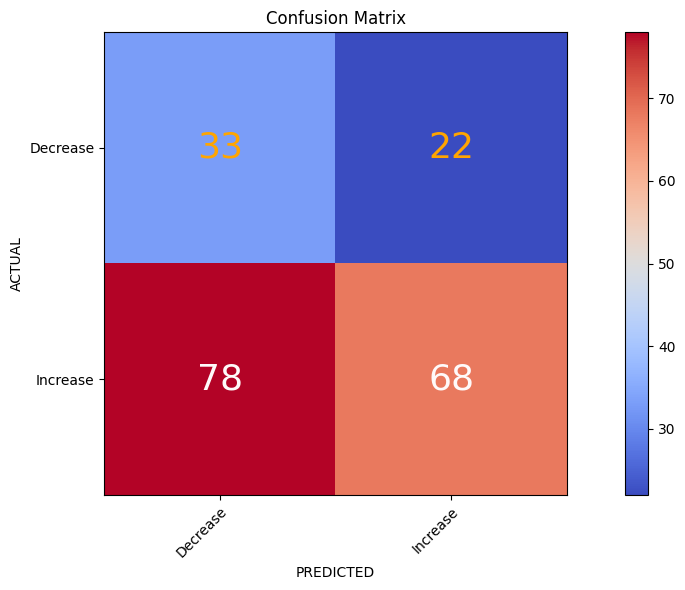

              precision    recall  f1-score   support

    Decrease       0.30      0.60      0.40        55
    Increase       0.76      0.47      0.58       146

    accuracy                           0.50       201
   macro avg       0.53      0.53      0.49       201
weighted avg       0.63      0.50      0.53       201


-------------- Logistic Regression ---------------



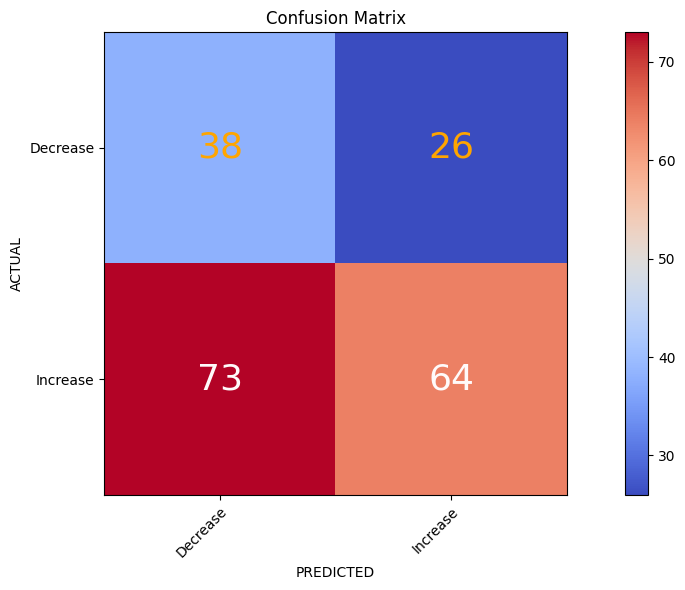

              precision    recall  f1-score   support

    Decrease       0.34      0.59      0.43        64
    Increase       0.71      0.47      0.56       137

    accuracy                           0.51       201
   macro avg       0.53      0.53      0.50       201
weighted avg       0.59      0.51      0.52       201


-------------- LinearDiscriminantAnalysis ---------------



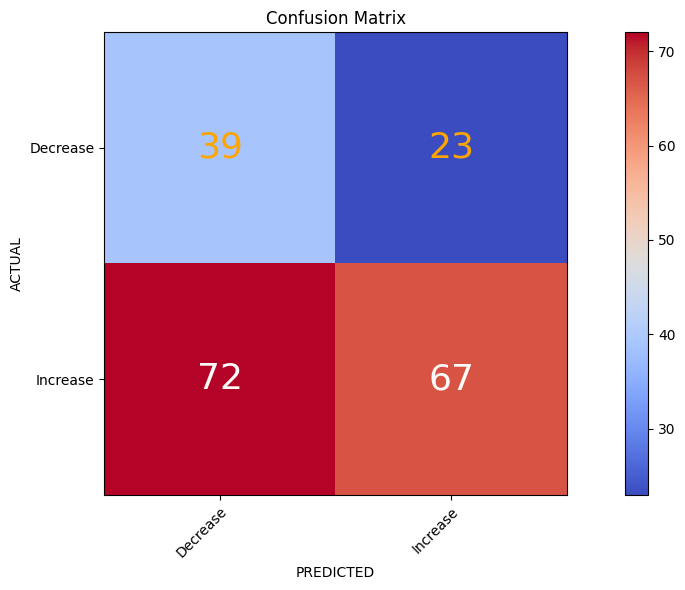

              precision    recall  f1-score   support

    Decrease       0.35      0.63      0.45        62
    Increase       0.74      0.48      0.59       139

    accuracy                           0.53       201
   macro avg       0.55      0.56      0.52       201
weighted avg       0.62      0.53      0.54       201


-------------- SVM Classification ---------------



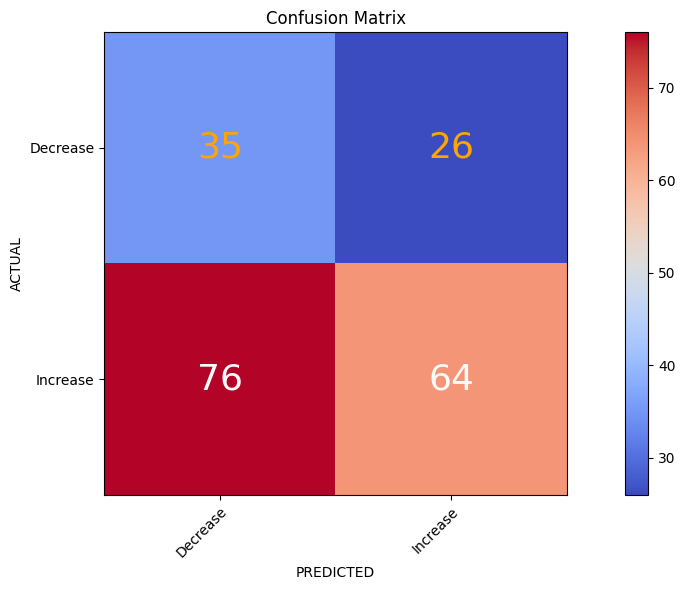

              precision    recall  f1-score   support

    Decrease       0.32      0.57      0.41        61
    Increase       0.71      0.46      0.56       140

    accuracy                           0.49       201
   macro avg       0.51      0.52      0.48       201
weighted avg       0.59      0.49      0.51       201


-------------- SGDClassifier ---------------



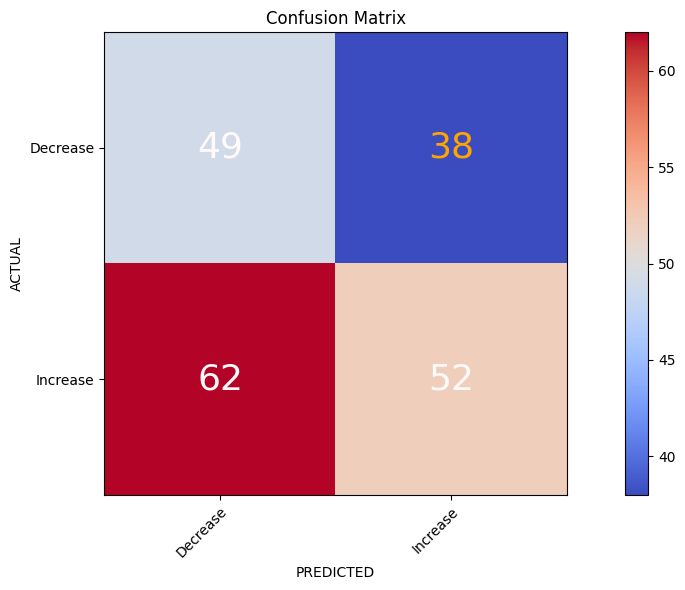

              precision    recall  f1-score   support

    Decrease       0.44      0.56      0.49        87
    Increase       0.58      0.46      0.51       114

    accuracy                           0.50       201
   macro avg       0.51      0.51      0.50       201
weighted avg       0.52      0.50      0.50       201


-------------- KNeighborsClassifier ---------------



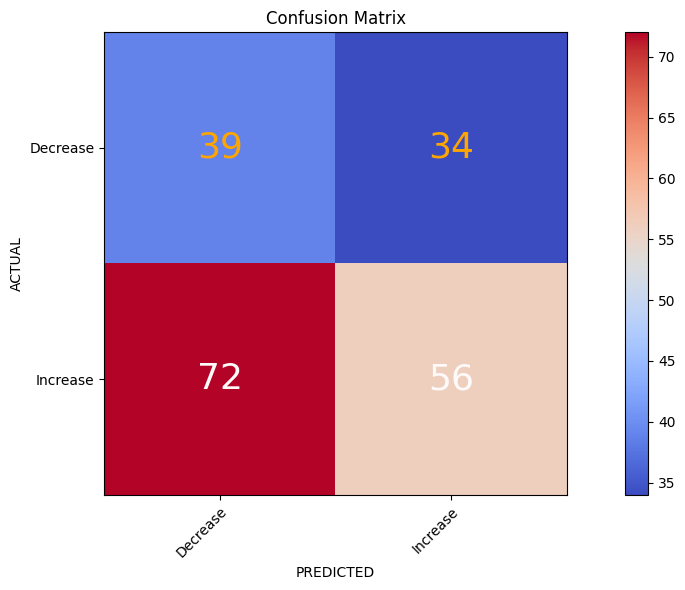

              precision    recall  f1-score   support

    Decrease       0.35      0.53      0.42        73
    Increase       0.62      0.44      0.51       128

    accuracy                           0.47       201
   macro avg       0.49      0.49      0.47       201
weighted avg       0.52      0.47      0.48       201


-------------- GaussianProcessClassifier ---------------



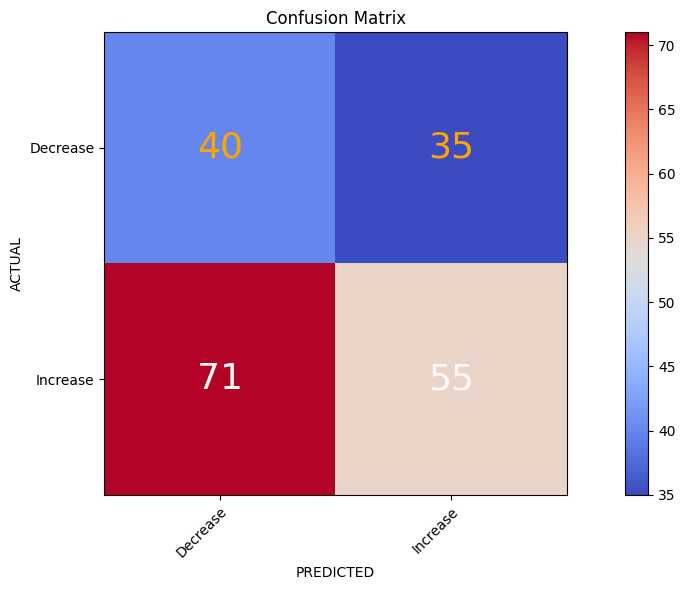

              precision    recall  f1-score   support

    Decrease       0.36      0.53      0.43        75
    Increase       0.61      0.44      0.51       126

    accuracy                           0.47       201
   macro avg       0.49      0.48      0.47       201
weighted avg       0.52      0.47      0.48       201


-------------- RandomForestClassifier ---------------



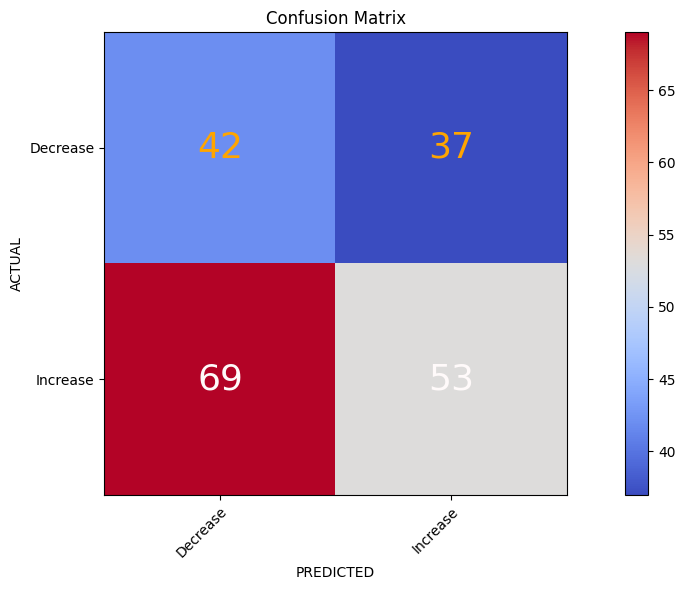

              precision    recall  f1-score   support

    Decrease       0.38      0.53      0.44        79
    Increase       0.59      0.43      0.50       122

    accuracy                           0.47       201
   macro avg       0.48      0.48      0.47       201
weighted avg       0.51      0.47      0.48       201



In [128]:
# test models
models = {  
            'Bernoulli NB': BernoulliNB(),
            'Logistic Regression' : LogisticRegression(),
            'LinearDiscriminantAnalysis':LinearDiscriminantAnalysis(),
            'SVM Classification': SVC(),
            'SGDClassifier': SGDClassifier(loss="hinge", penalty="l2", max_iter=100),
            'KNeighborsClassifier':KNeighborsClassifier(n_neighbors=9),
            'GaussianProcessClassifier': GaussianProcessClassifier(),
            'RandomForestClassifier': RandomForestClassifier(n_estimators=100)
            }

for model_name in models.keys():

    model = models[model_name]
    print('\n'+'--------------',model_name,'---------------'+'\n')
    model.fit(X_train,y_train)
    # Plot confusion matrix
    plot_confusion_matrix(model.predict(X_test),y_test, title="Confusion Matrix")
    #plot_matrix(model.predict(X_test),y_test)
    np.set_printoptions(precision=1)
    plt.show()
    # Final Classification Report
    print(classification_report(model.predict(X_test),y_test, target_names=['Decrease', 'Increase']))

### Conclusion

The precision score is the 'exactness', or ability of the model to return only relevant instances. When a model makes a prediction, how often it is correct? 

It appears that the model which correctly predicted the increase in price most often was the Random Forest Classifier at 66%, and the K-Nearest Neighbours Classifier was best at predicting the decrease in price 63% of the time. 

None of the scores were particularly outstanding and further improvements might include updating the lexicon with words and sentiments from other more specialised sources such as the [Loughran-McDonald Financial Sentiment Word Lists](https://sraf.nd.edu/textual-analysis/resources/#LM%20Sentiment%20Word%20Lists). This would likely result in more accurate sentiment analysis as it was specifically built for financial text whereas VADER is more attuned to sentiments expressed in social media.
